# NPZD slab model

For the first model example I will need:
- Forcing input
- Forcing_fluxes:
    - mixing
    - sinking
- 4 components (single) N, P, Z, D
- Fluxes:
TODO: GO OVER THE equations! Base model structure in math!
    - Grazing - linked to all NPZD
    - PhytoplanktonGrowth
        - Light - Dependence
        - Nutrients - Dependence
        - Temp - Dependence
    - mortality
    - remineralisation
    - higher order pred, etc

In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra as phydra

In [3]:
from phydra.utility.xsimlabwrappers import phydra_setup

In [4]:
from phydra.processes.main import Grid0D, Boundary0D
from phydra.processes.components import Component, Time, make_Component
from phydra.processes.environments import BaseEnvironment, Slab
from phydra.processes.fluxes import (BaseFlux, LimitedGrowth_MonodTempLight,  
                                     LinearMortality, GrazingFlux, 
                                     GrazingMultiFlux, make_flux,
                                    make_multiflux)
from phydra.processes.forcingfluxes import (LinearMortalityClosure, Mixing, Sinking, 
                                            Upwelling, make_FX_flux)
from phydra.processes.forcing import (SinusoidalMLD, ConstantN0, WOA2018_MLD, 
                                      WOA2018_N0, MODISaq_PAR, WOA2018_Tmld, 
                                      ConstantPAR, ConstantTemp)
from phydra.processes.gekkocontext import GekkoContext, GekkoSolve, InheritGekkoContext

In [5]:
from phydra.processes.forcing import NutrientForcing, MLDForcing

In [6]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.77.g38c64ff.dirty


In [7]:
model = xs.Model({
    'time':Time, 'grid':Grid0D, 'ibcs':Boundary0D, 
    
    'context':GekkoContext,
                  
    'N':make_Component('Nutrient','N'), 'P':make_Component('Phytoplankton','P'),
    'Z':make_Component('Zooplankton','Z'), 'D':make_Component('Detritus','D'),
    'Env':Slab, 
    
    # Fluxes
    'P_Growth':make_flux(LimitedGrowth_MonodTempLight, 'G'), 
    
    'P_LinMortality':make_flux(LinearMortality, 'M'), 
    
    'Grazing':make_multiflux(GrazingMultiFlux, 'X'), 
    
    # Closure (i.e. output from system)
    'Z_LinMortality':make_FX_flux(LinearMortalityClosure, 'M'),
    
    # ForcingFluxes
    'Sinking':make_FX_flux(Sinking, 'S'),
    'Upwelling':make_FX_flux(Upwelling, 'U'),
    
    'MLD':WOA2018_MLD, 
    'N0':WOA2018_N0, 
    'PAR':MODISaq_PAR,
    'Temp':WOA2018_Tmld,
    
    'solver':GekkoSolve
})

model

<xsimlab.Model (20 processes, 49 inputs)>
context
time
    days               [in] ('time',) time in days
grid
    length             [in]
    shape              [in]
ibcs
    ibc                [in] Initial Boundary Conditions
N
    dim                [in]
    init               [in]
P
    dim                [in]
    init               [in]
Z
    dim                [in]
    init               [in]
D
    init               [in]
    dim                [in]
Temp
    rbb                [in]
    lon                [in]
    lat                [in]
    smooth             [in] smoothing factor used to choose number ...
Z_LinMortality
    C_labels           [in] m label of component(s) that grows
    mortality_rate     [in] mortality rate of component
MLD
    rbb                [in]
    lon                [in]
    lat                [in]
    smooth             [in] smoothing factor used to choose number ...
PAR
    rbb                [in]
    lat                [in]
    lon                [in]

In [8]:
model.index_vars 


[('time', 'time'),
 ('N', 'N'),
 ('P', 'P'),
 ('Z', 'Z'),
 ('D', 'D'),
 ('Env', 'components'),
 ('Env', 'fluxes'),
 ('Env', 'forcingfluxes'),
 ('Env', 'forcings'),
 ('P_Growth', 'G'),
 ('P_LinMortality', 'M'),
 ('Grazing', 'X'),
 ('Z_LinMortality', 'M'),
 ('Sinking', 'S'),
 ('Upwelling', 'U')]

In [9]:
ForcingLocation = {
    'lat':40,
    'lon':20,
    'rbb':2, 
    'smooth':100
}
ForcingLocationNOSMOOTH = ForcingLocation.copy()
ForcingLocationNOSMOOTH['smooth'] = 1

In [10]:
in_ds = phydra_setup(
    model=model,
    input_vars={
        'time__days': ('time', np.arange(0, 365*3)), #365*
        
        'N':{'dim':1,'init':.1}, 
        'P':{'dim':1,'init':.1},
        'Z':{'dim':3,'init':0.1},
        'D':{'dim':1,'init':0.1},
        
        'P_Growth':{'mu':1.,
               'R_label':'N',
               'C_label':'P', 
               'halfsat':1.5,
                   
                'kw':0.04,
                'kc':0.03,
                'OptI':30},
        
        'P_LinMortality':{'mortality_rate':0.1,
               'R_label':'P',
               'C_label':'D'},
        
        'Grazing':{'grazing_rate':0.5,
               'halfsat':.1,
               'R_feed_prefs':[0.67,0.33],
               'R_labels':['P','D'],
               'C_labels':['Z']},
        
        'Z_LinMortality':{'mortality_rate':0.1,
               'C_labels':['Z']},
        
        'Sinking':{'kappa':0.1,
               'C_labels':['D','P']},
        
        'Upwelling':{'kappa':0.1,
               'C_labels':['N']},
        
        'PAR':ForcingLocationNOSMOOTH,
        'Temp':ForcingLocationNOSMOOTH,
        'N0':ForcingLocationNOSMOOTH,
        'MLD':ForcingLocation
    },
    output_vars={
        'Env__comp_output':None,
        'Env__flux_output':None,
        'Env__fxflux_output':None,
        'Env__forcing_output':None
    }
                 )

In [11]:
with model:
    out_ds = in_ds.xsimlab.run()

Initializing Gekko Context
Initializing Model Time
dimensions of component N are initialized at 1
Initializing component  N ['N']
dimensions of component P are initialized at 1
Initializing component  P ['P']
dimensions of component Z are initialized at 3
Initializing component  Z ['Z-0', 'Z-1', 'Z-2']
dimensions of component D are initialized at 1
Initializing component  D ['D']
ForcingBase is initialized: Temp
forcing flux Z_LinMortality is initialized at ['Z']
Initializing forcing flux Z_LinMortality for components ['Z']
ForcingBase is initialized: MLD
ForcingBase is initialized: PAR
ForcingBase is initialized: N0
forcing flux Upwelling is initialized at ['N']
Initializing forcing flux Upwelling for components ['N']
flux Grazing is initialized for ['P' 'D'] --> ['Z']
Initializing multiflux: Grazing-P&D2Z
(0, 0) (0, 0)
(0, 1) (0, 0)
(0, 2) (0, 0)
(0, 0) (0, 0)
(0, 1) (0, 0)
(0, 2) (0, 0)
defaultdict(<class 'list'>, {'Z': [((p11)*(((v3)^(2)))), ((p11)*(((v3)^(2)))), ((p11)*(((v3)^(2))

AttributeError: 'GrazingMultiFlux_X' object has no attribute 'All_R_dims'

In [12]:
out_ds

NameError: name 'out_ds' is not defined

In [23]:
a = [1,1,1,2]
b = [3,2]

np.outer(a,b)

array([[3, 2],
       [3, 2],
       [3, 2],
       [6, 4]])

In [ ]:
out_ds.Env__forcing_output.plot.line(x='time')

In [ ]:
out_ds.Env__forcing_output.sel(forcings='N0').plot(x='time')  #, time=np.arange(300,400)

In [ ]:
out_ds.Env__comp_output.plot.line(x='time')

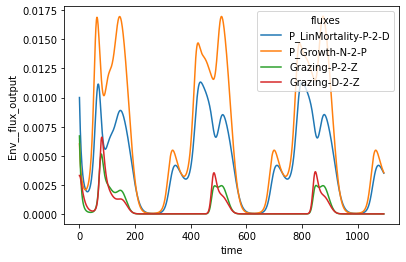

In [23]:
out_ds.Env__flux_output.plot.line(x='time')

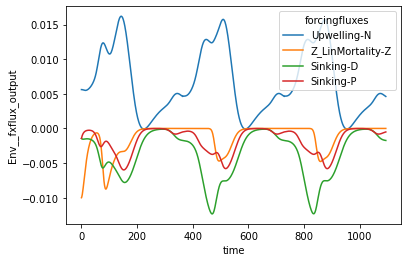

In [24]:
out_ds.Env__fxflux_output.plot.line(x='time')